In [1]:
# 1. Cài đặt các thư viện cần thiết
# !pip install torchaudio librosa soundfile scikit-learn matplotlib seaborn pandas tqdm gradio kagglehub

# 2. Import các thư viện cơ bản
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Dùng tqdm.notebook cho Colab
import re # Dùng để xử lý tên file EMO-DB

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Cấu hình device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Định nghĩa đường dẫn lưu mô hình (sẽ lưu tạm thời trong /content/)
MODEL_SAVE_PATH = '/content/trained_model.pt'
print(f"Model will be saved to: {MODEL_SAVE_PATH}")

# 3. Tải dữ liệu từ Kaggle sử dụng kagglehub
import kagglehub

print("\nDownloading datasets from Kaggle...")

# Dataset 1: Berlin Emotional Database (EMO-DB)
# kagglehub sẽ tự động tải và giải nén vào một thư mục cache, và trả về đường dẫn tới đó.
emodb_path = kagglehub.dataset_download("piyushagni5/berlin-database-of-emotional-speech-emodb")
print(f"EMO-DB downloaded to: {emodb_path}")

# Dataset 2: RAVDESS
ravdess_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print(f"RAVDESS downloaded to: {ravdess_path}")

# Dataset 3: TESS (Toronto Emotional Speech Set)
tess_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print(f"TESS downloaded to: {tess_path}")

# Kiểm tra cấu trúc thư mục của các dataset đã tải về
print("\nVerifying dataset structures:")
print(f"EMO-DB contents: {os.listdir(emodb_path)}")
print(f"RAVDESS contents: {os.listdir(ravdess_path)}")
print(f"TESS contents: {os.listdir(tess_path)}")



Using device: cuda
Model will be saved to: /content/trained_model.pt

EMO-DB downloaded to: /kaggle/input/berlin-database-of-emotional-speech-emodb
RAVDESS downloaded to: /kaggle/input/ravdess-emotional-speech-audio
TESS downloaded to: /kaggle/input/toronto-emotional-speech-set-tess

Verifying dataset structures:
EMO-DB contents: ['wav']
RAVDESS contents: ['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']
TESS contents: ['TESS Toronto emotional speech set data', 'tess toronto emotional speech set data']


In [ ]:
# 4. Phân tích cấu trúc dữ liệu và tạo DataFrame chung
all_audio_files = []

# --- RAVDESS Processing ---
ravdess_emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio"

ravdess_base_path = ravdess_path
for actor_dir in tqdm(os.listdir(ravdess_base_path), desc="Processing RAVDESS"):
    actor_path = os.path.join(ravdess_base_path, actor_dir)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                parts = filename.split('-')
                emotion_code = parts[2]
                emotion_name = ravdess_emotion_map.get(emotion_code)
                if emotion_name:
                    all_audio_files.append({
                        'filepath': os.path.join(actor_path, filename),
                        'emotion': emotion_name,
                        'dataset': 'RAVDESS'
                    })

# --- EMO-DB Processing ---

emodb_emotion_map = {
    'a': 'angry', 'd': 'disgust', 'f': 'fearful', 'h': 'happy',
    'n': 'neutral', 's': 'sad'
}
emodb_path = "/kaggle/input/berlin-database-of-emotional-speech-emodb"
emodb_base_path = os.path.join(emodb_path, "wav")
for filename in tqdm(os.listdir(emodb_base_path), desc="Processing EMO-DB"):
    if filename.endswith('.wav'):
        # Extract emotion code from the 6th character (index 5)
        # e.g., '03a01Fa.wav' -> 'a'
        emotion_code = filename[5]
        emotion_name = emodb_emotion_map.get(emotion_code)
        if emotion_name:
            all_audio_files.append({
                'filepath': os.path.join(emodb_base_path, filename),
                'emotion': emotion_name,
                'dataset': 'EMO-DB'
            })

# --- TESS Processing ---

tess_path = "/kaggle/input/toronto-emotional-speech-set-tess"
tess_base_path = os.path.join(tess_path, "TESS Toronto emotional speech set data")
tess_emotion_map = {
    'angry': 'angry', 'disgust': 'disgust', 'fear': 'fearful',
    'happy': 'happy', 'neutral': 'neutral', 'ps': 'surprised', 'sad': 'sad' # 'ps' is pleased surprise
}

for emotion_dir in tqdm(os.listdir(tess_base_path), desc="Processing TESS"):
    # Clean emotion_dir name (e.g., OAF_angry -> angry)
    emotion_key = emotion_dir.split('_')[-1].lower()
    emotion_name = tess_emotion_map.get(emotion_key)

    if emotion_name: # Only process if we have a valid emotion mapping
        emotion_path = os.path.join(tess_base_path, emotion_dir)
        if os.path.isdir(emotion_path):
            for filename in os.listdir(emotion_path):
                if filename.endswith('.wav'):
                    all_audio_files.append({
                        'filepath': os.path.join(emotion_path, filename),
                        'emotion': emotion_name,
                        'dataset': 'TESS'
                    })

df = pd.DataFrame(all_audio_files)

# Lọc các cảm xúc mong muốn (có thể điều chỉnh)
# Ví dụ: chỉ giữ happy, sad, angry, neutral, fearful, disgusted, surprised
selected_emotions = ['happy', 'sad', 'angry', 'neutral', 'fearful', 'disgust', 'surprised']
df = df[df['emotion'].isin(selected_emotions)].reset_index(drop=True)

print(f"Total audio files found: {len(df)}")
print("Emotion distribution:\n", df['emotion'].value_counts())

# Mã hóa nhãn cảm xúc sang số nguyên
label_to_int = {emotion: i for i, emotion in enumerate(df['emotion'].unique())}
int_to_label = {i: emotion for emotion, i in label_to_int.items()}
df['label'] = df['emotion'].map(label_to_int)

print("\nEmotion to integer mapping:", label_to_int)

# 5. Chia tập dữ liệu (Training, Validation, Test)
# Sử dụng stratified split để đảm bảo phân phối cảm xúc đồng đều trong các tập
X = df['filepath']
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # Fix: Should be X_val, X_test, y_val, y_test

train_df = pd.DataFrame({'filepath': X_train, 'label': y_train})
val_df = pd.DataFrame({'filepath': X_val, 'label': y_val})
test_df = pd.DataFrame({'filepath': X_test, 'label': y_test}) # Fix: Use y_test here

print(f"\nTrain samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# 6. Định nghĩa hàm trích xuất đặc trưng
# Tham số cố định cho trích xuất đặc trưng
SR = 22050 # Sample rate
N_MFCC = 40 # Số lượng MFCCs
# Tính toán MAX_PAD_LENGTH dựa trên độ dài trung bình của các file âm thanh trong dataset tổng hợp
# Hoặc giữ cố định một giá trị hợp lý (ví dụ ~4-5 giây âm thanh)
# Với SR=22050, hop_length=512, 1 khung ~ 512/22050 = 0.023 giây.
# 173 khung ~ 4 giây. Điều chỉnh nếu cần.
MAX_PAD_LENGTH = 173

def extract_features(audio_path, sr=SR, n_mfcc=N_MFCC, max_pad_length=MAX_PAD_LENGTH):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except Exception as e:
        # print(f"Error loading {audio_path}: {e}") # Có thể bỏ comment để debug
        return None

    # Trích xuất MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    rms = librosa.feature.rms(y=y)
    zcr = librosa.feature.zero_crossing_rate(y=y)

    features = np.vstack((mfccs, mfccs_delta, mfccs_delta2, rms, zcr))

    if features.shape[1] < max_pad_length:
        pad_width = max_pad_length - features.shape[1]
        features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    elif features.shape[1] > max_pad_length:
        features = features[:, :max_pad_length]

    return features.T # Return shape [time_steps, total_features]

# Test hàm trích xuất
test_audio_path = df.loc[0, 'filepath']
test_features = extract_features(test_audio_path)
if test_features is not None:
    print(f"\nShape of extracted features for {test_audio_path}: {test_features.shape}")
    assert test_features.shape[1] == (N_MFCC * 3 + 2)
    assert test_features.shape[0] == MAX_PAD_LENGTH
else:
    print("Feature extraction failed for test audio.")

# 7. Định nghĩa PyTorch Dataset (Không thay đổi)
class SERDataset(Dataset):
    def __init__(self, dataframe, scaler=None):
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe['label'].values
        self.scaler = scaler

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]

        features = extract_features(filepath)

        if features is None: # Handle cases where audio loading failed

            print(f"Warning: Skipping {filepath} due to feature extraction failure.")
            return torch.zeros((MAX_PAD_LENGTH, N_MFCC * 3 + 2), dtype=torch.float32), torch.tensor(0, dtype=torch.long)

        if self.scaler:
            features = self.scaler.transform(features)

        features_tensor = torch.tensor(features, dtype=torch.float32)
        features_tensor = features_tensor.unsqueeze(0) # Add channel dimension -> [1, time_steps, total_features]

        return features_tensor, torch.tensor(label, dtype=torch.long)

# 8. Huấn luyện StandardScaler trên tập huấn luyện để chuẩn hóa đặc trưng
print("\nFitting StandardScaler on training data...")
dummy_features_list = []
# Filter out None values that might result from extract_features
valid_train_filepaths = [fp for fp in train_df['filepath'] if extract_features(fp) is not None]

for filepath in tqdm(valid_train_filepaths, desc="Extracting features for scaler"):
    features = extract_features(filepath)
    dummy_features_list.append(features)

all_train_features = np.vstack(dummy_features_list)
scaler = StandardScaler()
scaler.fit(all_train_features)
print("StandardScaler fitted.")

# 9. Tạo các Dataset và DataLoader
# Cần lọc lại các dataframe để loại bỏ các file bị lỗi nếu có
train_df_filtered = train_df[train_df['filepath'].apply(lambda x: extract_features(x) is not None)].reset_index(drop=True)
val_df_filtered = val_df[val_df['filepath'].apply(lambda x: extract_features(x) is not None)].reset_index(drop=True)
test_df_filtered = test_df[test_df['filepath'].apply(lambda x: extract_features(x) is not None)].reset_index(drop=True)

train_dataset = SERDataset(train_df_filtered, scaler)
val_dataset = SERDataset(val_df_filtered, scaler)
test_dataset = SERDataset(test_df_filtered, scaler)

# Xử lý mất cân bằng lớp bằng WeightedRandomSampler
class_counts = train_df_filtered['label'].value_counts().sort_index().values
num_samples = len(train_df_filtered) # Use the actual number of samples in the filtered training set
class_weights = num_samples / (len(label_to_int) * class_counts)
weights_tensor = torch.tensor([class_weights[label] for label in train_df_filtered['label']], dtype=torch.double)
sampler = WeightedRandomSampler(weights_tensor, num_samples=num_samples, replacement=True) # Use the calculated num_samples

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nNumber of features (channels for CNN): {N_MFCC * 3 + 2}")
print(f"Sequence length (time steps for CNN): {MAX_PAD_LENGTH}")

for batch_features, batch_labels in train_loader:
    print(f"\nBatch features shape: {batch_features.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Processing RAVDESS:   0%|          | 0/25 [00:00<?, ?it/s]

Processing EMO-DB:   0%|          | 0/535 [00:00<?, ?it/s]

Processing TESS:   0%|          | 0/14 [00:00<?, ?it/s]

Total audio files found: 3648
Emotion distribution:
 emotion
disgust      592
sad          592
fearful      592
happy        592
angry        592
neutral      496
surprised    192
Name: count, dtype: int64

Emotion to integer mapping: {'surprised': 0, 'neutral': 1, 'disgust': 2, 'fearful': 3, 'sad': 4, 'happy': 5, 'angry': 6}

Train samples: 2553
Validation samples: 547
Test samples: 548

Shape of extracted features for /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav: (173, 122)

Fitting StandardScaler on training data...


Extracting features for scaler:   0%|          | 0/2553 [00:00<?, ?it/s]

StandardScaler fitted.

Number of features (channels for CNN): 122
Sequence length (time steps for CNN): 173

Batch features shape: torch.Size([32, 1, 173, 122])
Batch labels shape: torch.Size([32])


In [3]:
# 10. Định nghĩa Mô hình CNN-BiLSTM
class CNNBiLSTM(nn.Module):
    def __init__(self, num_classes, total_features, max_pad_length):
        super(CNNBiLSTM, self).__init__()

        # CNN Layers để trích xuất đặc trưng không gian cục bộ
        # Input: [batch_size, 1, time_steps, total_features]
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        # Tính toán kích thước output của CNN để đưa vào BiLSTM
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, max_pad_length, total_features) # [batch, channels, time_steps, features]
            dummy_output = self.conv1(dummy_input)
            dummy_output = self.conv2(dummy_output)

            self.lstm_input_size = dummy_output.shape[1] * dummy_output.shape[3] # 64 * W_out
            self.lstm_sequence_length = dummy_output.shape[2] # H_out (time dimension)

            print(f"Calculated LSTM input size: {self.lstm_input_size}")
            print(f"Calculated LSTM sequence length: {self.lstm_sequence_length}")

        # BiLSTM Layers để học thông tin tuần tự
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(self.lstm.hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: [batch_size, 1, MAX_PAD_LENGTH, total_features]

        # CNN layers
        x = self.conv1(x)
        x = self.conv2(x)
        # Output x shape: [batch_size, 64, H_out, W_out]

        # Reshape for BiLSTM: treat H_out as sequence length, and 64 * W_out as input_size for LSTM
        x = x.permute(0, 2, 1, 3).contiguous() # -> [batch_size, H_out, 64, W_out]
        x = x.view(x.size(0), x.size(1), -1) # -> [batch_size, H_out, 64 * W_out]

        # BiLSTM layers
        lstm_out, _ = self.lstm(x) # lstm_out shape: [batch_size, H_out, hidden_size * 2]

        # Average pooling across the sequence length for classification
        x = torch.mean(lstm_out, dim=1) # -> [batch_size, hidden_size * 2]

        # Fully connected layers
        logits = self.fc(x)
        return logits

# Khởi tạo mô hình
num_classes = len(label_to_int)
total_features = N_MFCC * 3 + 2
model = CNNBiLSTM(num_classes, total_features, MAX_PAD_LENGTH).to(device)
print("\nModel Architecture:")
print(model)

# Kiểm tra một lượt forward pass
dummy_input = torch.randn(BATCH_SIZE, 1, MAX_PAD_LENGTH, total_features).to(device)
dummy_output = model(dummy_input)
print(f"\nDummy output shape: {dummy_output.shape}")
assert dummy_output.shape[1] == num_classes

Calculated LSTM input size: 1920
Calculated LSTM sequence length: 43

Model Architecture:
CNNBiLSTM(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(1920, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=7, bias=True)
  )
)

Dummy output shape


Starting training...


Epoch 1 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1/50] Train Loss: 1.2350, Train Acc: 0.5742, Train F1: 0.5653 | Val Loss: 0.6880, Val Acc: 0.7441, Val F1: 0.7242
Saved best model with F1: 0.7242


Epoch 2 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2/50] Train Loss: 0.6904, Train Acc: 0.7693, Train F1: 0.7722 | Val Loss: 0.5270, Val Acc: 0.7989, Val F1: 0.7853
Saved best model with F1: 0.7853


Epoch 3 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3/50] Train Loss: 0.4852, Train Acc: 0.8382, Train F1: 0.8381 | Val Loss: 0.5726, Val Acc: 0.7678, Val F1: 0.7526


Epoch 4 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/50] Train Loss: 0.4436, Train Acc: 0.8543, Train F1: 0.8543 | Val Loss: 0.4398, Val Acc: 0.8300, Val F1: 0.8186
Saved best model with F1: 0.8186


Epoch 5 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/50] Train Loss: 0.3515, Train Acc: 0.8821, Train F1: 0.8823 | Val Loss: 0.4200, Val Acc: 0.8501, Val F1: 0.8416
Saved best model with F1: 0.8416


Epoch 6 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [6/50] Train Loss: 0.2877, Train Acc: 0.9040, Train F1: 0.9022 | Val Loss: 0.4239, Val Acc: 0.8428, Val F1: 0.8278


Epoch 7 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/50] Train Loss: 0.2586, Train Acc: 0.9115, Train F1: 0.9113 | Val Loss: 0.3770, Val Acc: 0.8647, Val F1: 0.8580
Saved best model with F1: 0.8580


Epoch 8 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [8/50] Train Loss: 0.2188, Train Acc: 0.9315, Train F1: 0.9316 | Val Loss: 0.3801, Val Acc: 0.8720, Val F1: 0.8623
Saved best model with F1: 0.8623


Epoch 9 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/50] Train Loss: 0.1919, Train Acc: 0.9448, Train F1: 0.9444 | Val Loss: 0.4120, Val Acc: 0.8665, Val F1: 0.8422


Epoch 10 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/50] Train Loss: 0.1357, Train Acc: 0.9597, Train F1: 0.9593 | Val Loss: 0.3583, Val Acc: 0.8684, Val F1: 0.8518


Epoch 11 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 11 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [11/50] Train Loss: 0.1398, Train Acc: 0.9593, Train F1: 0.9585 | Val Loss: 0.3229, Val Acc: 0.9049, Val F1: 0.9012
Saved best model with F1: 0.9012


Epoch 12 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 12 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [12/50] Train Loss: 0.1162, Train Acc: 0.9636, Train F1: 0.9633 | Val Loss: 0.2840, Val Acc: 0.8921, Val F1: 0.8863


Epoch 13 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 13 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [13/50] Train Loss: 0.1183, Train Acc: 0.9663, Train F1: 0.9661 | Val Loss: 0.3258, Val Acc: 0.8812, Val F1: 0.8790


Epoch 14 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 14 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [14/50] Train Loss: 0.0910, Train Acc: 0.9730, Train F1: 0.9729 | Val Loss: 0.3885, Val Acc: 0.8775, Val F1: 0.8650


Epoch 15 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 15 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [15/50] Train Loss: 0.0777, Train Acc: 0.9773, Train F1: 0.9772 | Val Loss: 0.4612, Val Acc: 0.8684, Val F1: 0.8625


Epoch 16 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 16 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [16/50] Train Loss: 0.0565, Train Acc: 0.9839, Train F1: 0.9841 | Val Loss: 0.4004, Val Acc: 0.8995, Val F1: 0.8964


Epoch 17 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 17 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [17/50] Train Loss: 0.1259, Train Acc: 0.9640, Train F1: 0.9642 | Val Loss: 0.4931, Val Acc: 0.8355, Val F1: 0.8268


Epoch 18 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 18 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [18/50] Train Loss: 0.1112, Train Acc: 0.9718, Train F1: 0.9715 | Val Loss: 0.2814, Val Acc: 0.9086, Val F1: 0.9019
Saved best model with F1: 0.9019


Epoch 19 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 19 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [19/50] Train Loss: 0.0381, Train Acc: 0.9918, Train F1: 0.9920 | Val Loss: 0.3235, Val Acc: 0.9122, Val F1: 0.9087
Saved best model with F1: 0.9087


Epoch 20 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 20 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [20/50] Train Loss: 0.0146, Train Acc: 0.9976, Train F1: 0.9976 | Val Loss: 0.3832, Val Acc: 0.9068, Val F1: 0.9025


Epoch 21 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 21 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [21/50] Train Loss: 0.0082, Train Acc: 0.9992, Train F1: 0.9992 | Val Loss: 0.3992, Val Acc: 0.9068, Val F1: 0.9033


Epoch 22 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 22 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [22/50] Train Loss: 0.0062, Train Acc: 0.9996, Train F1: 0.9996 | Val Loss: 0.4040, Val Acc: 0.9141, Val F1: 0.9106
Saved best model with F1: 0.9106


Epoch 23 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 23 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [23/50] Train Loss: 0.0047, Train Acc: 0.9992, Train F1: 0.9992 | Val Loss: 0.4160, Val Acc: 0.9141, Val F1: 0.9103


Epoch 24 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 24 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [24/50] Train Loss: 0.0029, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.4366, Val Acc: 0.9104, Val F1: 0.9071


Epoch 25 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 25 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [25/50] Train Loss: 0.0034, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.4514, Val Acc: 0.9159, Val F1: 0.9098


Epoch 26 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 26 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [26/50] Train Loss: 0.0039, Train Acc: 0.9996, Train F1: 0.9996 | Val Loss: 0.4865, Val Acc: 0.9104, Val F1: 0.9056


Epoch 27 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 27 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [27/50] Train Loss: 0.0027, Train Acc: 0.9996, Train F1: 0.9996 | Val Loss: 0.4887, Val Acc: 0.9159, Val F1: 0.9101


Epoch 28 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 28 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [28/50] Train Loss: 0.0020, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5179, Val Acc: 0.9122, Val F1: 0.9087


Epoch 29 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 29 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [29/50] Train Loss: 0.0021, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5240, Val Acc: 0.9122, Val F1: 0.9072


Epoch 30 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 30 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [30/50] Train Loss: 0.0025, Train Acc: 0.9996, Train F1: 0.9996 | Val Loss: 0.6403, Val Acc: 0.8885, Val F1: 0.8868


Epoch 31 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 31 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [31/50] Train Loss: 0.0083, Train Acc: 0.9976, Train F1: 0.9976 | Val Loss: 0.6100, Val Acc: 0.8940, Val F1: 0.8892


Epoch 32 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 32 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [32/50] Train Loss: 0.0035, Train Acc: 0.9996, Train F1: 0.9996 | Val Loss: 0.5388, Val Acc: 0.9013, Val F1: 0.8955


Epoch 33 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 33 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [33/50] Train Loss: 0.0024, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5354, Val Acc: 0.9068, Val F1: 0.9000


Epoch 34 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 34 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [34/50] Train Loss: 0.0020, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5433, Val Acc: 0.9049, Val F1: 0.8984


Epoch 35 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 35 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [35/50] Train Loss: 0.0021, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5538, Val Acc: 0.9068, Val F1: 0.8999


Epoch 36 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 36 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [36/50] Train Loss: 0.0016, Train Acc: 0.9996, Train F1: 0.9996 | Val Loss: 0.5638, Val Acc: 0.9049, Val F1: 0.8979


Epoch 37 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 37 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [37/50] Train Loss: 0.0017, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5634, Val Acc: 0.9086, Val F1: 0.9012


Epoch 38 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 38 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [38/50] Train Loss: 0.0014, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5645, Val Acc: 0.9068, Val F1: 0.8996


Epoch 39 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 39 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [39/50] Train Loss: 0.0014, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5565, Val Acc: 0.9031, Val F1: 0.8966


Epoch 40 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 40 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [40/50] Train Loss: 0.0014, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5605, Val Acc: 0.9031, Val F1: 0.8966


Epoch 41 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 41 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [41/50] Train Loss: 0.0020, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5629, Val Acc: 0.9068, Val F1: 0.8998


Epoch 42 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 42 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [42/50] Train Loss: 0.0022, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5605, Val Acc: 0.9104, Val F1: 0.9036


Epoch 43 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 43 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [43/50] Train Loss: 0.0012, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5623, Val Acc: 0.9049, Val F1: 0.8982


Epoch 44 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 44 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [44/50] Train Loss: 0.0010, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5664, Val Acc: 0.9049, Val F1: 0.8982


Epoch 45 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 45 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [45/50] Train Loss: 0.0016, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5712, Val Acc: 0.9049, Val F1: 0.8982


Epoch 46 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 46 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [46/50] Train Loss: 0.0024, Train Acc: 0.9992, Train F1: 0.9992 | Val Loss: 0.5764, Val Acc: 0.9086, Val F1: 0.9015


Epoch 47 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 47 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [47/50] Train Loss: 0.0020, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5791, Val Acc: 0.9104, Val F1: 0.9033


Epoch 48 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 48 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [48/50] Train Loss: 0.0011, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5792, Val Acc: 0.9068, Val F1: 0.8999


Epoch 49 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 49 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [49/50] Train Loss: 0.0014, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5817, Val Acc: 0.9086, Val F1: 0.9016


Epoch 50 Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 50 Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [50/50] Train Loss: 0.0013, Train Acc: 1.0000, Train F1: 1.0000 | Val Loss: 0.5821, Val Acc: 0.9104, Val F1: 0.9033

Training complete!


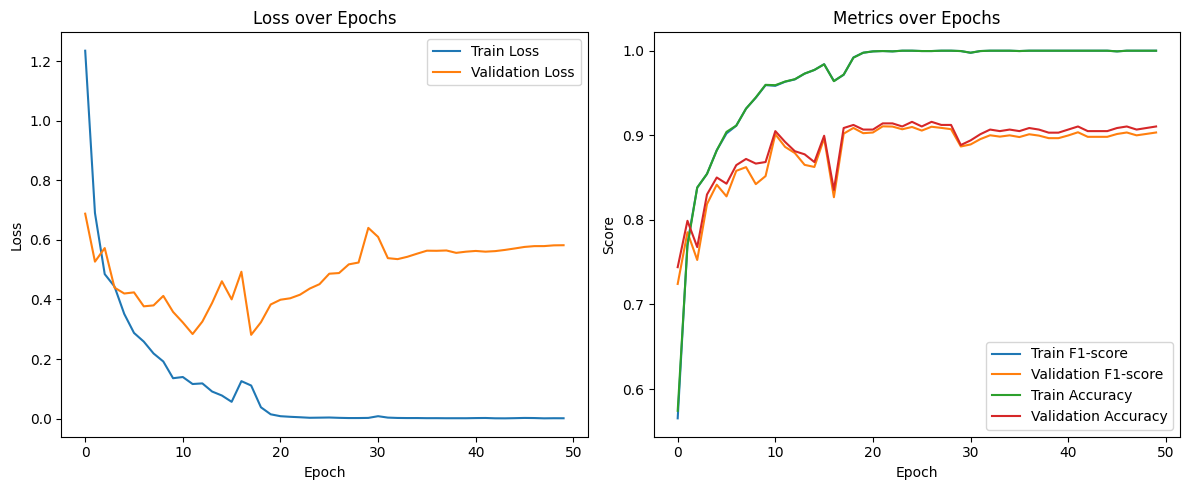


Evaluating model on test set...


Test Evaluation:   0%|          | 0/18 [00:00<?, ?it/s]


Test Loss: 0.4219, Test Acc: 0.9197, Test F1: 0.9144


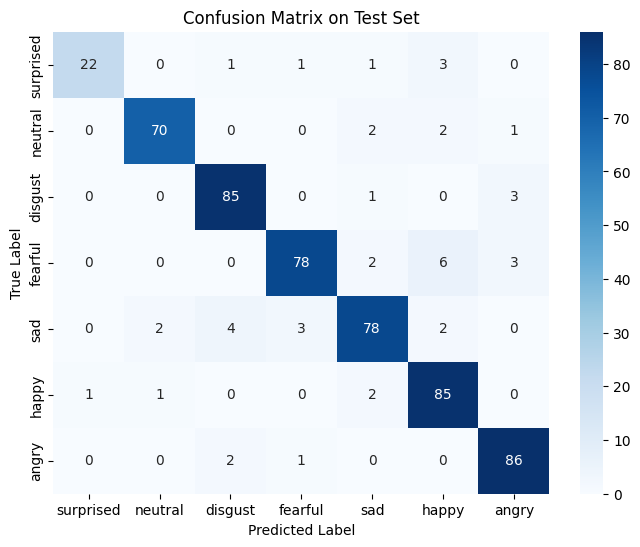

In [4]:
# 11. Định nghĩa hàm tính metrics
def calculate_metrics(y_true, y_pred, average='macro'):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average)
    return accuracy, f1

# 12. Cấu hình huấn luyện
LEARNING_RATE = 0.001
NUM_EPOCHS = 50 # Bạn có thể tăng số epoch nếu cần

criterion = nn.CrossEntropyLoss().to(device) # CrossEntropyLoss bao gồm Softmax
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # Thêm weight_decay để chống overfit
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# 13. Vòng lặp huấn luyện
best_val_f1 = 0.0

print("\nStarting training...")
history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
           'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch_idx, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc, train_f1 = calculate_metrics(all_train_labels, all_train_preds)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            features = features.to(device)
            labels = labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc, val_f1 = calculate_metrics(all_val_labels, all_val_preds)

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    scheduler.step(val_f1)

    # Lưu mô hình tốt nhất
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Saved best model with F1: {best_val_f1:.4f}")

print("\nTraining complete!")

# 14. Vẽ biểu đồ quá trình huấn luyện
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1-score')
plt.plot(history['val_f1'], label='Validation F1-score')
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# 15. Đánh giá mô hình trên tập kiểm thử (Test Set)
print("\nEvaluating model on test set...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device)) # Tải mô hình tốt nhất
model.eval()

total_test_loss = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for features, labels in tqdm(test_loader, desc="Test Evaluation"):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

avg_test_loss = total_test_loss / len(test_loader)
test_acc, test_f1 = calculate_metrics(all_test_labels, all_test_preds)

print(f"\nTest Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

# Vẽ Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(int_to_label.values()),
            yticklabels=list(int_to_label.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [6]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 90.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Demo

In [ ]:
# # 16. Hàm dự đoán cho một file âm thanh
# def predict_single_audio(audio_path, model, scaler, label_to_int, int_to_label, sr=SR, n_mfcc=N_MFCC, max_pad_length=MAX_PAD_LENGTH, device=device):
#     # Trích xuất đặc trưng
#     features = extract_features(audio_path, sr, n_mfcc, max_pad_length)
#     if features is None:
#         return "Error: Could not process audio file.", None, None, None

#     # Chuẩn hóa
#     features = scaler.transform(features)
    
#     # Chuyển đổi sang Tensor và thêm chiều batch, channel
#     features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0) # [1, 1, time_steps, total_features]
#     features_tensor = features_tensor.to(device)

#     # Dự đoán
#     model.eval()
#     with torch.no_grad():
#         outputs = model(features_tensor)
#         probabilities = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
        
#     predicted_label_idx = np.argmax(probabilities)
#     predicted_emotion = int_to_label[predicted_label_idx]

#     # Tạo biểu đồ xác suất
#     fig = plt.figure(figsize=(8, 4))
#     sns.barplot(x=list(int_to_label.values()), y=probabilities, palette='viridis')
#     plt.title('Emotion Probabilities')
#     plt.xlabel('Emotion')
#     plt.ylabel('Probability')
#     plt.ylim(0, 1)
#     plt.close(fig) # Đóng figure để tránh hiển thị trong notebook, Gradio sẽ dùng nó

#     return predicted_emotion, fig, audio_path, probabilities

# # Tải lại mô hình đã huấn luyện cho inference
# inference_model = CNNBiLSTM(num_classes, total_features, MAX_PAD_LENGTH).to(device)
# inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
# inference_model.eval()
# print(f"Inference model loaded from {MODEL_SAVE_PATH}")

# # 17. Hàm wrapper cho Gradio
# import traceback

# import tempfile

# import tempfile
# import os

# def gradio_predict(audio_input):
#     try:
#         if audio_input is None:
#             return "No audio provided.", None, None

#         if isinstance(audio_input, str):  # File upload
#             audio_path = audio_input

#         elif isinstance(audio_input, tuple):  # Microphone input
#             sr_mic, y_mic = audio_input
#             print("Microphone Input - Sampling rate:", sr_mic)
#             print("Microphone Input - Shape:", y_mic.shape)

#             #  Ghi ra thư mục /tmp (được Gradio cho phép)
#             with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir="/tmp") as tmpfile:
#                 sf.write(tmpfile.name, y_mic, sr_mic)
#                 audio_path = tmpfile.name
#                 print("Temp audio path:", audio_path)

#         else:
#             return "Invalid audio input format.", None, None

#         # Dự đoán
#         predicted_emotion, plot_fig, original_audio_path, probabilities = predict_single_audio(
#             audio_path, inference_model, scaler, label_to_int, int_to_label, device=device
#         )

#         if predicted_emotion.startswith("Error"):
#             return predicted_emotion, None, None

#         return predicted_emotion, plot_fig, audio_path  #  file trong /tmp được phép trả về

#     except Exception as e:
#         import traceback
#         tb = traceback.format_exc()
#         print("Exception:\n", tb)
#         return f"Exception occurred:\n{tb}", None, None

#     # Example audio path for Gradio, pick one from the loaded dataset
#     # For instance, a RAVDESS file:
#     # Get a sample RAVDESS file for the example
#     ravdess_sample_file = ""
#     for path in df['filepath']:
#         if "RAVDESS" in path: # Check if it's a RAVDESS file
#             ravdess_sample_file = path
#             break
    
#     # Or an EMO-DB sample
#     emodb_sample_file = ""
#     for path in df['filepath']:
#         if "emo-db" in path: # Check if it's an EMO-DB file
#             emodb_sample_file = path
#             break

#     # Or a TESS sample
#     tess_sample_file = ""
#     for path in df['filepath']:
#         if "TESS" in path: # Check if it's a TESS file
#             tess_sample_file = path
#             break

#         if isinstance(audio_input, tuple):
#             return predicted_emotion, plot_fig, None
#         else:
#             return predicted_emotion, plot_fig, original_audio_path
# # 18. Tạo giao diện Gradio
# import gradio as gr

# # Example files for Gradio interface (adjust paths if needed)
# example_files = []
# # Add a few example files from the downloaded datasets if they exist
# if len(df) > 0:
#     # Try to add examples from different datasets if possible
#     ravdess_ex = df[df['dataset'] == 'RAVDESS']['filepath'].iloc[0] if not df[df['dataset'] == 'RAVDESS'].empty else None
#     emodb_ex = df[df['dataset'] == 'EMO-DB']['filepath'].iloc[0] if not df[df['dataset'] == 'EMO-DB'].empty else None
#     tess_ex = df[df['dataset'] == 'TESS']['filepath'].iloc[0] if not df[df['dataset'] == 'TESS'].empty else None
    
#     if ravdess_ex: example_files.append([ravdess_ex])
#     if emodb_ex: example_files.append([emodb_ex])
#     if tess_ex: example_files.append([tess_ex])

# file_upload_interface = gr.Interface(
#     fn=gradio_predict,
#     inputs=gr.Audio(type="filepath", label="Upload a .wav file"),
#     outputs=[
#         gr.Textbox(label="Predicted Emotion"),
#         gr.Plot(label="Emotion Probabilities"),
#         gr.Audio(label="Original Audio Playback", format="wav")
#     ],
#     title="Speech Emotion Recognition (SER)",
#     description="Upload an audio file (.wav) to predict the emotion expressed.",
#     examples=example_files if example_files else None
# )


# # Kết hợp hai giao diện thành một TabbedInterface
# demo = gr.TabbedInterface(
#     [file_upload_interface, microphone_interface],
#     ["Upload Audio", "Record from Microphone"]
# )

# print("\nLaunching Gradio demo...")
# demo.launch(share=True)